In [38]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


    Note: run in megabouts_dlc

In [39]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import tables
import flammkuchen as fl

# Computation
from scipy.interpolate import interp1d

#custom functions
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.signal.signaltools import correlate

from tqdm import tqdm

In [40]:
from segmentation_helper import nanzscore, reduce_to_pi, compute_tailsum, moving_average, smooth_trace

In [41]:
from megabouts.utils import (
    bouts_category_name,
    bouts_category_name_short,
    bouts_category_color,
    cmp_bouts,
)

# Set up paths

In [42]:
master_path = Path(Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Koetter-et-al_data\Testdata') / 'Raw_Data')
out_path = Path(master_path/'Processed_Data')
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths

[WindowsPath('//portulab.synology.me/data/Kata/Figures_Paper/Koetter-et-al_data/Testdata/Raw_Data/240423_f0')]

In [43]:
fish= 0
fish_path = fish_paths[fish]
fish_id =  fish_paths[fish].name
exp_name = 'testfish'
exp_name, fish_id

('testfish', '240423_f0')

In [44]:
print ("{} videos found".format(len(fish_paths)))

1 videos found


In [45]:
bout_duration = 50

## Load and mask data

In [46]:
data = fl.load(out_path/'{}_bout_data.h5'.format(fish_id))
data.keys()

dict_keys(['body_angles', 'body_angles_delta', 'bout_times', 'cluster', 'dlc_filter', 'edge_filter', 'eye_angles', 'eye_rotation', 'eye_vergence', 'fin_angles', 'laterality', 'mb_proba', 'motor', 'tail_vectors', 'tailsums'])

In [47]:
dlc_filter = data['dlc_filter']
edge_filter = data['edge_filter']
mb_proba = data['mb_proba']

np.unique(dlc_filter), np.unique(edge_filter) #, np.unique(mb_proba)

(array([-1,  1], dtype=int64), array([ True]))

In [48]:
mask = dlc_filter ==1
mask.shape

(506,)

In [49]:
clusters = data['cluster'][:,0][mask]
tail_vectors = data['tail_vectors'][mask]
tailsums = data['tailsums'] [mask]
l_fin = data['fin_angles'][:,0,:][mask]
r_fin = data['fin_angles'][:,1,:][mask]
clusters.shape, tailsums.shape

((505,), (505, 50))

In [50]:
## True = boputs in circle

mask_2 = edge_filter[mask] == True 
mask_2.shape

(505,)

In [51]:
clusters = clusters[mask_2]
tail_vectors =tail_vectors[mask_2]
tailsums = tailsums[mask_2]
l_fin = l_fin[mask_2]
r_fin = r_fin[mask_2]

In [52]:
clusters.shape

(505,)

In [53]:
mask_3 = mb_proba[mask][mask_2] >=0.60

mb_proba[mask][mask_2][mask_3].shape

(460,)

In [54]:
clusters = clusters[mask_3]
tail_vectors =tail_vectors[mask_3]
tailsums = tailsums[mask_3]
l_fin = l_fin[mask_3]
r_fin = r_fin[mask_3]

In [55]:
n_clust = np.unique(clusters).shape[0]
n_clust

10

### Test smoothing

In [56]:
from scipy.signal import savgol_filter

def smooth_trace(trace, wnd=6, poly=2):
    return savgol_filter(trace, wnd, poly)  # window size 5, polynomial order 2

def smooth_trace_tail(trace, wnd=3, poly=2):
    return savgol_filter(trace, wnd, poly)  # window size 5, polynomial order 2

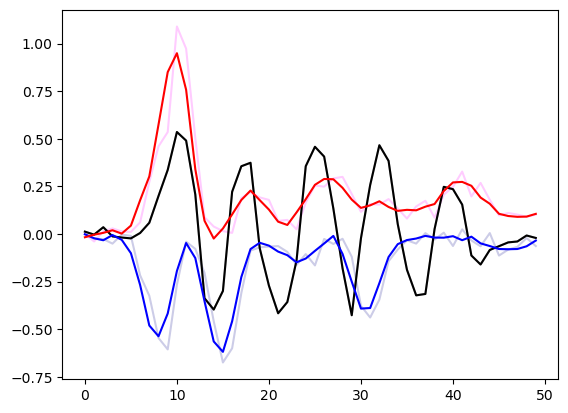

In [57]:
# Generate a random integer from 0 to num_elements - 1
bout = np.random.randint(0, np.asarray(clusters).shape[0])
plt.figure()

sm_tail = smooth_trace_tail(tailsums[bout])
sm_l_fin = smooth_trace(l_fin[bout])
sm_r_fin = smooth_trace(r_fin[bout])

plt.plot(np.asarray(tailsums)[bout], c='k', alpha=0.2)
plt.plot(np.asarray(l_fin)[bout, :], c='darkblue', alpha=0.2)
plt.plot(np.asarray(r_fin)[bout,:], c='magenta', alpha=0.2)

plt.plot(sm_tail, c='k')
plt.plot(sm_l_fin, c='blue')
plt.plot(sm_r_fin, c='r')

### tails are good enough?

In [58]:
tailsums = np.apply_along_axis(smooth_trace_tail, 1, tailsums)
l_fin = np.apply_along_axis(smooth_trace, 1, l_fin)
r_fin = np.apply_along_axis(smooth_trace, 1, r_fin)

In [67]:
laterality =data['laterality'][mask][mask_2][mask_3]
fl.save(out_path/ '{}_bout_laterality.h5', laterality)

In [60]:
tailsums.shape, laterality.shape

((460, 50), (460,))

In [61]:
np.unique(clusters), np.max(clusters)

(array([ 0,  1,  2,  5,  6,  7,  8,  9, 11, 12]), 12)

In [62]:
n_clust = np.unique(clusters).shape[0]
n_clust =  np.max(clusters)+1
n_clust

13

### Plot traces

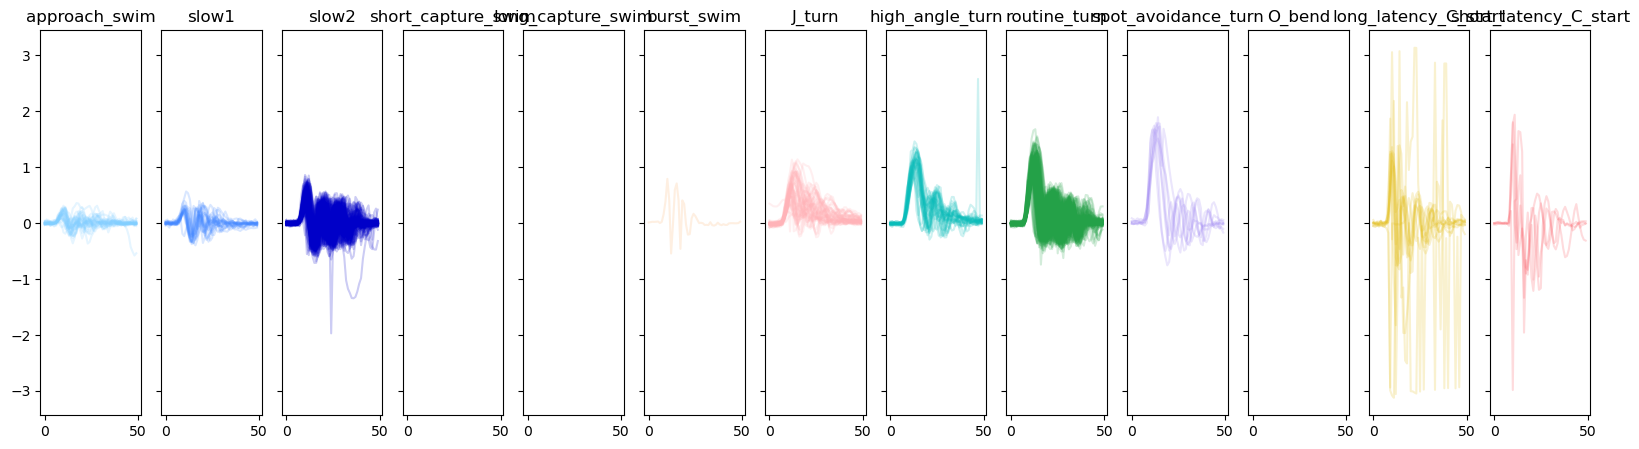

In [63]:
alph = 0.2
fig, axes = plt.subplots(1,n_clust, figsize=(20, 5), sharex=True, sharey=True)
axes= axes.ravel()

for clust in range(n_clust):
    axes[clust].set_title(bouts_category_name[clust])
    axes[clust].plot(tailsums[clusters==clust][laterality[clusters==clust]==1].T, c=bouts_category_color[clust], alpha=alph)
    axes[clust].plot((tailsums[clusters==clust][laterality[clusters==clust]==-1].T)*-1, c=bouts_category_color[clust], alpha=alph)

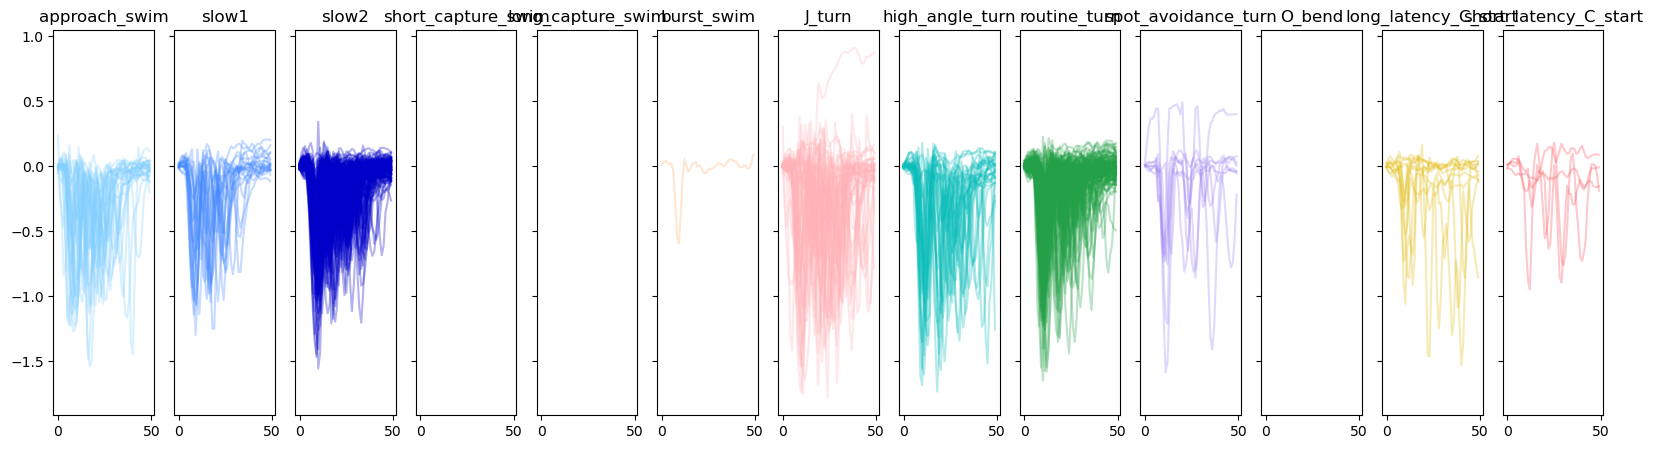

In [64]:
fig, axes = plt.subplots(1,n_clust, figsize=(20, 5), sharex=True, sharey=True)
axes= axes.ravel()

for clust in range(n_clust):
    axes[clust].set_title(bouts_category_name[clust])
    axes[clust].plot(l_fin[clusters==clust].T, c=bouts_category_color[clust], alpha=0.3)

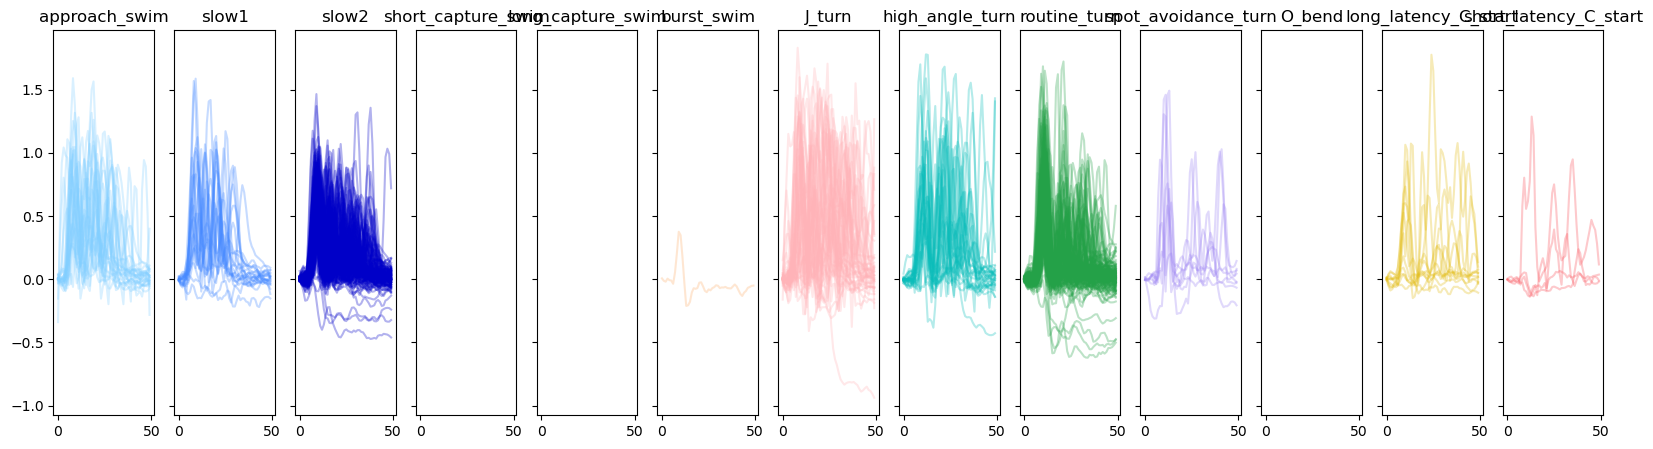

In [65]:
fig, axes = plt.subplots(1,n_clust, figsize=(20, 5), sharex=True, sharey=True)
axes= axes.ravel()

for clust in range(n_clust):
    axes[clust].set_title(bouts_category_name[clust])
    axes[clust].plot(r_fin[clusters==clust].T, c=bouts_category_color[clust], alpha=0.3)

### check extracted data

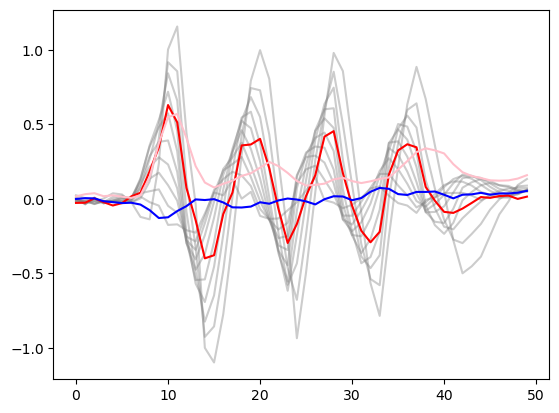

In [66]:
# Generate a random integer from 0 to num_elements - 1
bout = np.random.randint(0, np.asarray(clusters).shape[0])
plt.figure()
plt.plot(np.asarray(tail_vectors)[bout, :, :10], c='gray', alpha=0.4)
plt.plot(np.asarray(tailsums)[bout], c='r')
plt.plot(np.asarray(l_fin)[bout, :], c='blue')
plt.plot(np.asarray(r_fin)[bout,:], c='pink')